# Combined Capsule Networks for Sentiment Analysis

This notebook introduces and implements a Combined Capsule Network in Keras and evaluates its performance for Sentiment Analysis on IMDB Dataset. The developed architecture is presented below.

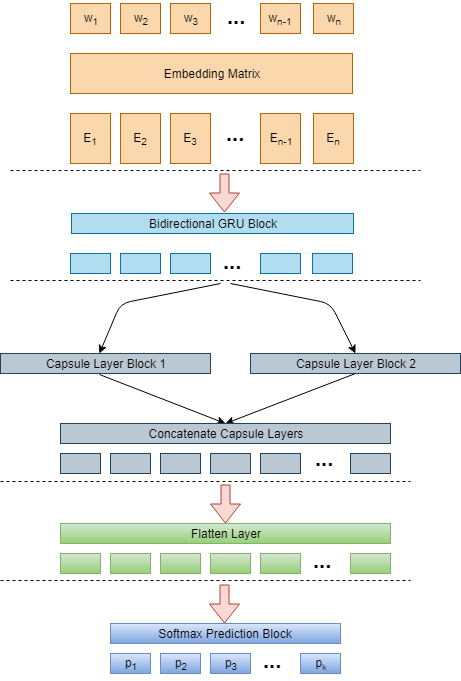

In [1]:
from IPython.display import Image
Image('sentiment-capsule-networks.png')

## Essential imports

In [2]:
import gc
import os
import nltk
import tqdm
import numpy as np
import pandas as pd
nltk.download("punkt")

from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.engine import Layer
from keras.layers import Activation, Add, Bidirectional, Conv1D, Dense, Dropout, Embedding, Flatten
from keras.layers import concatenate, GRU, Input, K, LSTM, MaxPooling1D
from keras.layers import GlobalAveragePooling1D,  GlobalMaxPooling1D, SpatialDropout1D
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing import text, sequence
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
from sklearn.model_selection import train_test_split
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.layers import Embedding

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alisu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Using TensorFlow backend.


## Load Data - Training and Testing Data

In [3]:
from keras.datasets import imdb

In [4]:
print('Loading data...')
num_words = 1_000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words,
                                                      skip_top=25)

print('Data loaded.')

print(f'{len(x_train):,} train sequences')
print(f'{len(x_test):,} test sequences')

Loading data...
Data loaded.
25,000 train sequences
25,000 test sequences


## Data Preprocessing

In [5]:
print("Number of categories: ", len(set(y_train)))


Number of categories:  2


In [6]:
from keras.preprocessing import sequence


In [7]:
max_words = 100
x_train = sequence.pad_sequences(x_train, maxlen=max_words)
x_test = sequence.pad_sequences(x_test, maxlen=max_words)

In [8]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (25000, 100)
x_test shape: (25000, 100)


In [9]:
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Dropout, Activation, Flatten

## Capsule Networks

### CapsNet parameters

In [10]:
gru_len = 128
Routings = 5
Num_capsule = 10
Dim_capsule = 16
Dim_capsule1 = 32
dropout_p = 0.3
rate_drop_dense = 0.3
Dim1_capsule = 8

batch_size = 128 # 256
recurrent_units = 16 # 64
dropout_rate = 0.3 
dense_size = 8 # 32
sentences_length = 100 # 300
fold_count = 2 # 10

def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True)
    scale = K.sqrt(s_squared_norm + K.epsilon())
    return x / scale

### Capsule Layer

In [11]:
class Capsule(Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, kernel_size=(3, 1), share_weights=True,
                 activation='default', **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_size = kernel_size
        self.share_weights = share_weights
        if activation == 'default':
            self.activation = squash
        else:
            self.activation = Activation(activation)

    def build(self, input_shape):
        super(Capsule, self).build(input_shape)
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(1, input_dim_capsule,
                                            self.num_capsule * self.dim_capsule),
                                     # shape=self.kernel_size,
                                     initializer='glorot_uniform',
                                     trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(input_num_capsule,
                                            input_dim_capsule,
                                            self.num_capsule * self.dim_capsule),
                                     initializer='glorot_uniform',
                                     trainable=True)

    def call(self, u_vecs):
        if self.share_weights:
            u_hat_vecs = K.conv1d(u_vecs, self.W)
        else:
            u_hat_vecs = K.local_conv1d(u_vecs, self.W, [1], [1])

        batch_size = K.shape(u_vecs)[0]
        input_num_capsule = K.shape(u_vecs)[1]
        u_hat_vecs = K.reshape(u_hat_vecs, (batch_size, input_num_capsule,
                                            self.num_capsule, self.dim_capsule))
        u_hat_vecs = K.permute_dimensions(u_hat_vecs, (0, 2, 1, 3))
        # final u_hat_vecs.shape = [None, num_capsule, input_num_capsule, dim_capsule]

        b = K.zeros_like(u_hat_vecs[:, :, :, 0])  # shape = [None, num_capsule, input_num_capsule]
        for i in range(self.routings):
            b = K.permute_dimensions(b, (0, 2, 1))  # shape = [None, input_num_capsule, num_capsule]
            c = K.softmax(b)
            c = K.permute_dimensions(c, (0, 2, 1))
            b = K.permute_dimensions(b, (0, 2, 1))
            outputs = self.activation(K.batch_dot(c, u_hat_vecs, [2, 2]))
            if i < self.routings - 1:
                b = K.batch_dot(outputs, u_hat_vecs, [2, 3])

        return outputs

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

### Creating a Model

In [12]:
embedding_dimension = 500
num_words = 20000
max_len = 100


def get_model(embedding_matrix, sequence_length, dropout_rate, recurrent_units, dense_size):
    input1 = Input(shape=(sequence_length,))
    embed_layer = Embedding(num_words, embedding_dimension, input_length=max_len)(input1)
    embed_layer = SpatialDropout1D(rate_drop_dense)(embed_layer)

    x = Bidirectional(
        GRU(gru_len, activation='relu', dropout=dropout_p, recurrent_dropout=dropout_p, return_sequences=True))(
        embed_layer)
    
    
    capsule = Capsule(num_capsule=Num_capsule, dim_capsule=Dim_capsule, routings=Routings,
                      share_weights=True)(x)
    capsule1 = Capsule(num_capsule=Num_capsule, dim_capsule=Dim_capsule1, routings=Routings,
                      share_weights=True)(x)

    capsule = concatenate([capsule, capsule1], axis=-1)
    capsule = Flatten()(capsule)
    capsule = Dropout(dropout_p)(capsule)
    

    output = Dense(1, activation = "sigmoid")(capsule)
    model = Model(inputs=input1, outputs=output)
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])
    model.summary()
    return model

In [13]:
model=get_model(Embedding,
    sentences_length,
    dropout_rate,
    recurrent_units,
    dense_size)

W0816 12:58:28.428478 10672 deprecation_wrapper.py:118] From C:\Users\alisu\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0816 12:58:28.478364 10672 deprecation.py:506] From C:\Users\alisu\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0816 12:58:29.688255 10672 deprecation_wrapper.py:118] From C:\Users\alisu\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0816 12:58:29.717239 10672 deprecation.py:323] From C:\Users\alisu\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\ops\nn_impl.py:183: where

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 500)     10000000    input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 100, 500)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 100, 256)     483072      spatial_dropout1d_1[0][0]        
__________________________________________________________________________________________________
capsule_1 

### Training

In [14]:
model.fit(x_train, y_train, batch_size=32, epochs=5, validation_split=0.1)

Train on 22500 samples, validate on 2500 samples
Epoch 1/5


 6496/22500 [=======>......................] - ETA: 1:49:23 - loss: 0.7058 - acc: 0.46 - ETA: 58:37 - loss: 0.8003 - acc: 0.4375 - ETA: 41:27 - loss: 0.7727 - acc: 0.46 - ETA: 32:50 - loss: 0.7355 - acc: 0.53 - ETA: 27:40 - loss: 0.7403 - acc: 0.51 - ETA: 24:13 - loss: 0.7401 - acc: 0.51 - ETA: 21:45 - loss: 0.7314 - acc: 0.50 - ETA: 20:02 - loss: 0.7268 - acc: 0.51 - ETA: 18:36 - loss: 0.7172 - acc: 0.54 - ETA: 17:44 - loss: 0.7189 - acc: 0.52 - ETA: 16:59 - loss: 0.7156 - acc: 0.53 - ETA: 16:11 - loss: 0.7180 - acc: 0.52 - ETA: 15:28 - loss: 0.7207 - acc: 0.51 - ETA: 14:52 - loss: 0.7182 - acc: 0.51 - ETA: 14:20 - loss: 0.7185 - acc: 0.51 - ETA: 13:52 - loss: 0.7173 - acc: 0.51 - ETA: 13:27 - loss: 0.7166 - acc: 0.51 - ETA: 13:05 - loss: 0.7167 - acc: 0.51 - ETA: 12:44 - loss: 0.7156 - acc: 0.51 - ETA: 12:26 - loss: 0.7152 - acc: 0.51 - ETA: 12:10 - loss: 0.7138 - acc: 0.51 - ETA: 11:55 - loss: 0.7130 - acc: 0.51 - ETA: 11:44 - loss: 0.7131 - acc: 0.51 - ETA: 11:33 - loss: 0.7103 - a

13024/22500 [================>.............] - ETA: 5:53 - loss: 0.5621 - acc: 0.679 - ETA: 5:52 - loss: 0.5605 - acc: 0.680 - ETA: 5:52 - loss: 0.5599 - acc: 0.681 - ETA: 5:51 - loss: 0.5587 - acc: 0.682 - ETA: 5:50 - loss: 0.5578 - acc: 0.682 - ETA: 5:49 - loss: 0.5579 - acc: 0.682 - ETA: 5:48 - loss: 0.5566 - acc: 0.683 - ETA: 5:47 - loss: 0.5566 - acc: 0.683 - ETA: 5:46 - loss: 0.5554 - acc: 0.684 - ETA: 5:45 - loss: 0.5551 - acc: 0.684 - ETA: 5:45 - loss: 0.5544 - acc: 0.685 - ETA: 5:44 - loss: 0.5536 - acc: 0.685 - ETA: 5:43 - loss: 0.5531 - acc: 0.686 - ETA: 5:42 - loss: 0.5521 - acc: 0.687 - ETA: 5:41 - loss: 0.5516 - acc: 0.687 - ETA: 5:40 - loss: 0.5506 - acc: 0.688 - ETA: 5:39 - loss: 0.5500 - acc: 0.688 - ETA: 5:39 - loss: 0.5502 - acc: 0.688 - ETA: 5:38 - loss: 0.5506 - acc: 0.689 - ETA: 5:37 - loss: 0.5495 - acc: 0.689 - ETA: 5:36 - loss: 0.5489 - acc: 0.690 - ETA: 5:35 - loss: 0.5488 - acc: 0.690 - ETA: 5:34 - loss: 0.5482 - acc: 0.691 - ETA: 5:34 - loss: 0.5479 - acc: 0

19552/22500 [=========================>....] - ETA: 3:19 - loss: 0.4944 - acc: 0.738 - ETA: 3:18 - loss: 0.4944 - acc: 0.738 - ETA: 3:17 - loss: 0.4943 - acc: 0.738 - ETA: 3:17 - loss: 0.4940 - acc: 0.738 - ETA: 3:16 - loss: 0.4941 - acc: 0.738 - ETA: 3:15 - loss: 0.4937 - acc: 0.739 - ETA: 3:15 - loss: 0.4935 - acc: 0.739 - ETA: 3:14 - loss: 0.4935 - acc: 0.739 - ETA: 3:13 - loss: 0.4934 - acc: 0.739 - ETA: 3:13 - loss: 0.4931 - acc: 0.739 - ETA: 3:12 - loss: 0.4928 - acc: 0.739 - ETA: 3:11 - loss: 0.4925 - acc: 0.740 - ETA: 3:10 - loss: 0.4919 - acc: 0.740 - ETA: 3:10 - loss: 0.4917 - acc: 0.740 - ETA: 3:09 - loss: 0.4912 - acc: 0.741 - ETA: 3:08 - loss: 0.4914 - acc: 0.741 - ETA: 3:08 - loss: 0.4913 - acc: 0.741 - ETA: 3:07 - loss: 0.4911 - acc: 0.741 - ETA: 3:06 - loss: 0.4909 - acc: 0.741 - ETA: 3:06 - loss: 0.4905 - acc: 0.741 - ETA: 3:05 - loss: 0.4905 - acc: 0.741 - ETA: 3:04 - loss: 0.4903 - acc: 0.741 - ETA: 3:03 - loss: 0.4901 - acc: 0.742 - ETA: 3:03 - loss: 0.4900 - acc: 0

22500/22500 [==============================] - ETA: 1:00 - loss: 0.4640 - acc: 0.765 - ETA: 59s - loss: 0.4638 - acc: 0.766 - ETA: 59s - loss: 0.4634 - acc: 0.76 - ETA: 58s - loss: 0.4635 - acc: 0.76 - ETA: 57s - loss: 0.4634 - acc: 0.76 - ETA: 57s - loss: 0.4632 - acc: 0.76 - ETA: 56s - loss: 0.4628 - acc: 0.76 - ETA: 55s - loss: 0.4624 - acc: 0.76 - ETA: 55s - loss: 0.4621 - acc: 0.76 - ETA: 54s - loss: 0.4620 - acc: 0.76 - ETA: 53s - loss: 0.4617 - acc: 0.76 - ETA: 53s - loss: 0.4615 - acc: 0.76 - ETA: 52s - loss: 0.4612 - acc: 0.76 - ETA: 51s - loss: 0.4611 - acc: 0.76 - ETA: 51s - loss: 0.4610 - acc: 0.76 - ETA: 50s - loss: 0.4608 - acc: 0.76 - ETA: 49s - loss: 0.4611 - acc: 0.76 - ETA: 49s - loss: 0.4609 - acc: 0.76 - ETA: 48s - loss: 0.4607 - acc: 0.76 - ETA: 47s - loss: 0.4607 - acc: 0.76 - ETA: 47s - loss: 0.4605 - acc: 0.76 - ETA: 46s - loss: 0.4604 - acc: 0.76 - ETA: 45s - loss: 0.4600 - acc: 0.76 - ETA: 45s - loss: 0.4598 - acc: 0.76 - ETA: 44s - loss: 0.4598 - acc: 0.76 - 

 6528/22500 [=======>......................] - ETA: 7:34 - loss: 0.2880 - acc: 0.906 - ETA: 7:28 - loss: 0.3613 - acc: 0.843 - ETA: 7:26 - loss: 0.4002 - acc: 0.812 - ETA: 7:25 - loss: 0.3705 - acc: 0.843 - ETA: 7:23 - loss: 0.3826 - acc: 0.843 - ETA: 7:23 - loss: 0.3650 - acc: 0.859 - ETA: 7:22 - loss: 0.3667 - acc: 0.852 - ETA: 7:21 - loss: 0.3676 - acc: 0.847 - ETA: 7:20 - loss: 0.3574 - acc: 0.843 - ETA: 7:20 - loss: 0.3723 - acc: 0.834 - ETA: 7:19 - loss: 0.3819 - acc: 0.823 - ETA: 7:18 - loss: 0.3735 - acc: 0.830 - ETA: 7:17 - loss: 0.3815 - acc: 0.822 - ETA: 7:17 - loss: 0.3716 - acc: 0.830 - ETA: 7:16 - loss: 0.3690 - acc: 0.831 - ETA: 7:15 - loss: 0.3636 - acc: 0.835 - ETA: 7:15 - loss: 0.3639 - acc: 0.832 - ETA: 7:14 - loss: 0.3691 - acc: 0.831 - ETA: 7:13 - loss: 0.3816 - acc: 0.825 - ETA: 7:13 - loss: 0.3837 - acc: 0.820 - ETA: 7:12 - loss: 0.3842 - acc: 0.821 - ETA: 7:11 - loss: 0.3759 - acc: 0.828 - ETA: 7:11 - loss: 0.3805 - acc: 0.820 - ETA: 7:10 - loss: 0.3780 - acc: 0

13056/22500 [================>.............] - ETA: 5:18 - loss: 0.3922 - acc: 0.823 - ETA: 5:17 - loss: 0.3923 - acc: 0.822 - ETA: 5:16 - loss: 0.3920 - acc: 0.822 - ETA: 5:16 - loss: 0.3919 - acc: 0.822 - ETA: 5:15 - loss: 0.3917 - acc: 0.822 - ETA: 5:15 - loss: 0.3927 - acc: 0.822 - ETA: 5:14 - loss: 0.3926 - acc: 0.822 - ETA: 5:13 - loss: 0.3929 - acc: 0.822 - ETA: 5:13 - loss: 0.3929 - acc: 0.822 - ETA: 5:12 - loss: 0.3926 - acc: 0.822 - ETA: 5:11 - loss: 0.3923 - acc: 0.822 - ETA: 5:11 - loss: 0.3925 - acc: 0.822 - ETA: 5:10 - loss: 0.3930 - acc: 0.822 - ETA: 5:09 - loss: 0.3927 - acc: 0.822 - ETA: 5:09 - loss: 0.3927 - acc: 0.822 - ETA: 5:08 - loss: 0.3923 - acc: 0.822 - ETA: 5:07 - loss: 0.3920 - acc: 0.823 - ETA: 5:07 - loss: 0.3918 - acc: 0.823 - ETA: 5:06 - loss: 0.3914 - acc: 0.823 - ETA: 5:05 - loss: 0.3918 - acc: 0.823 - ETA: 5:05 - loss: 0.3914 - acc: 0.823 - ETA: 5:04 - loss: 0.3919 - acc: 0.823 - ETA: 5:04 - loss: 0.3925 - acc: 0.823 - ETA: 5:03 - loss: 0.3924 - acc: 0

19584/22500 [=========================>....] - ETA: 3:08 - loss: 0.3886 - acc: 0.826 - ETA: 3:07 - loss: 0.3883 - acc: 0.826 - ETA: 3:07 - loss: 0.3880 - acc: 0.826 - ETA: 3:06 - loss: 0.3879 - acc: 0.826 - ETA: 3:05 - loss: 0.3877 - acc: 0.826 - ETA: 3:05 - loss: 0.3878 - acc: 0.826 - ETA: 3:04 - loss: 0.3878 - acc: 0.826 - ETA: 3:04 - loss: 0.3882 - acc: 0.826 - ETA: 3:03 - loss: 0.3877 - acc: 0.826 - ETA: 3:02 - loss: 0.3879 - acc: 0.826 - ETA: 3:02 - loss: 0.3877 - acc: 0.826 - ETA: 3:01 - loss: 0.3878 - acc: 0.826 - ETA: 3:00 - loss: 0.3875 - acc: 0.826 - ETA: 3:00 - loss: 0.3880 - acc: 0.826 - ETA: 2:59 - loss: 0.3880 - acc: 0.826 - ETA: 2:58 - loss: 0.3877 - acc: 0.826 - ETA: 2:58 - loss: 0.3879 - acc: 0.826 - ETA: 2:57 - loss: 0.3879 - acc: 0.826 - ETA: 2:57 - loss: 0.3881 - acc: 0.826 - ETA: 2:56 - loss: 0.3879 - acc: 0.826 - ETA: 2:55 - loss: 0.3883 - acc: 0.826 - ETA: 2:55 - loss: 0.3887 - acc: 0.825 - ETA: 2:54 - loss: 0.3886 - acc: 0.826 - ETA: 2:53 - loss: 0.3893 - acc: 0

22500/22500 [==============================] - ETA: 58s - loss: 0.3867 - acc: 0.82 - ETA: 57s - loss: 0.3867 - acc: 0.82 - ETA: 56s - loss: 0.3870 - acc: 0.82 - ETA: 56s - loss: 0.3869 - acc: 0.82 - ETA: 55s - loss: 0.3869 - acc: 0.82 - ETA: 54s - loss: 0.3868 - acc: 0.82 - ETA: 54s - loss: 0.3870 - acc: 0.82 - ETA: 53s - loss: 0.3870 - acc: 0.82 - ETA: 52s - loss: 0.3867 - acc: 0.82 - ETA: 52s - loss: 0.3864 - acc: 0.82 - ETA: 51s - loss: 0.3865 - acc: 0.82 - ETA: 50s - loss: 0.3863 - acc: 0.82 - ETA: 50s - loss: 0.3861 - acc: 0.82 - ETA: 49s - loss: 0.3861 - acc: 0.82 - ETA: 49s - loss: 0.3865 - acc: 0.82 - ETA: 48s - loss: 0.3865 - acc: 0.82 - ETA: 47s - loss: 0.3865 - acc: 0.82 - ETA: 47s - loss: 0.3865 - acc: 0.82 - ETA: 46s - loss: 0.3864 - acc: 0.82 - ETA: 45s - loss: 0.3867 - acc: 0.82 - ETA: 45s - loss: 0.3867 - acc: 0.82 - ETA: 44s - loss: 0.3865 - acc: 0.82 - ETA: 43s - loss: 0.3867 - acc: 0.82 - ETA: 43s - loss: 0.3868 - acc: 0.82 - ETA: 42s - loss: 0.3868 - acc: 0.82 - ETA

 6528/22500 [=======>......................] - ETA: 7:57 - loss: 0.3381 - acc: 0.875 - ETA: 7:45 - loss: 0.3294 - acc: 0.859 - ETA: 7:40 - loss: 0.2959 - acc: 0.895 - ETA: 7:42 - loss: 0.2778 - acc: 0.906 - ETA: 7:42 - loss: 0.3170 - acc: 0.881 - ETA: 7:41 - loss: 0.3108 - acc: 0.880 - ETA: 7:40 - loss: 0.3267 - acc: 0.866 - ETA: 7:38 - loss: 0.3137 - acc: 0.871 - ETA: 7:37 - loss: 0.3229 - acc: 0.868 - ETA: 7:36 - loss: 0.3066 - acc: 0.875 - ETA: 7:35 - loss: 0.3155 - acc: 0.869 - ETA: 7:34 - loss: 0.3070 - acc: 0.875 - ETA: 7:33 - loss: 0.3105 - acc: 0.867 - ETA: 7:32 - loss: 0.3185 - acc: 0.863 - ETA: 7:31 - loss: 0.3205 - acc: 0.864 - ETA: 7:30 - loss: 0.3200 - acc: 0.865 - ETA: 7:29 - loss: 0.3254 - acc: 0.864 - ETA: 7:28 - loss: 0.3343 - acc: 0.859 - ETA: 7:28 - loss: 0.3414 - acc: 0.855 - ETA: 7:27 - loss: 0.3423 - acc: 0.857 - ETA: 7:27 - loss: 0.3378 - acc: 0.858 - ETA: 7:27 - loss: 0.3370 - acc: 0.858 - ETA: 7:26 - loss: 0.3333 - acc: 0.860 - ETA: 7:25 - loss: 0.3399 - acc: 0

13056/22500 [================>.............] - ETA: 5:30 - loss: 0.3595 - acc: 0.841 - ETA: 5:29 - loss: 0.3591 - acc: 0.841 - ETA: 5:29 - loss: 0.3588 - acc: 0.841 - ETA: 5:28 - loss: 0.3584 - acc: 0.842 - ETA: 5:28 - loss: 0.3585 - acc: 0.842 - ETA: 5:27 - loss: 0.3595 - acc: 0.841 - ETA: 5:27 - loss: 0.3591 - acc: 0.842 - ETA: 5:26 - loss: 0.3587 - acc: 0.842 - ETA: 5:25 - loss: 0.3580 - acc: 0.843 - ETA: 5:25 - loss: 0.3581 - acc: 0.843 - ETA: 5:24 - loss: 0.3582 - acc: 0.843 - ETA: 5:23 - loss: 0.3581 - acc: 0.843 - ETA: 5:23 - loss: 0.3576 - acc: 0.844 - ETA: 5:22 - loss: 0.3567 - acc: 0.844 - ETA: 5:22 - loss: 0.3569 - acc: 0.844 - ETA: 5:21 - loss: 0.3564 - acc: 0.844 - ETA: 5:20 - loss: 0.3557 - acc: 0.845 - ETA: 5:20 - loss: 0.3563 - acc: 0.845 - ETA: 5:19 - loss: 0.3559 - acc: 0.845 - ETA: 5:18 - loss: 0.3569 - acc: 0.844 - ETA: 5:18 - loss: 0.3574 - acc: 0.844 - ETA: 5:17 - loss: 0.3569 - acc: 0.844 - ETA: 5:16 - loss: 0.3575 - acc: 0.844 - ETA: 5:16 - loss: 0.3570 - acc: 0

19584/22500 [=========================>....] - ETA: 3:15 - loss: 0.3686 - acc: 0.837 - ETA: 3:15 - loss: 0.3685 - acc: 0.837 - ETA: 3:14 - loss: 0.3685 - acc: 0.837 - ETA: 3:13 - loss: 0.3687 - acc: 0.837 - ETA: 3:13 - loss: 0.3689 - acc: 0.837 - ETA: 3:12 - loss: 0.3686 - acc: 0.837 - ETA: 3:11 - loss: 0.3688 - acc: 0.837 - ETA: 3:11 - loss: 0.3684 - acc: 0.837 - ETA: 3:10 - loss: 0.3683 - acc: 0.838 - ETA: 3:09 - loss: 0.3682 - acc: 0.837 - ETA: 3:09 - loss: 0.3685 - acc: 0.837 - ETA: 3:08 - loss: 0.3683 - acc: 0.837 - ETA: 3:07 - loss: 0.3683 - acc: 0.838 - ETA: 3:07 - loss: 0.3686 - acc: 0.837 - ETA: 3:06 - loss: 0.3685 - acc: 0.837 - ETA: 3:05 - loss: 0.3683 - acc: 0.837 - ETA: 3:05 - loss: 0.3682 - acc: 0.837 - ETA: 3:04 - loss: 0.3683 - acc: 0.837 - ETA: 3:03 - loss: 0.3681 - acc: 0.838 - ETA: 3:03 - loss: 0.3683 - acc: 0.838 - ETA: 3:02 - loss: 0.3684 - acc: 0.838 - ETA: 3:01 - loss: 0.3683 - acc: 0.838 - ETA: 3:01 - loss: 0.3687 - acc: 0.837 - ETA: 3:00 - loss: 0.3686 - acc: 0

22500/22500 [==============================] - ETA: 1:00 - loss: 0.3682 - acc: 0.837 - ETA: 59s - loss: 0.3679 - acc: 0.837 - ETA: 58s - loss: 0.3681 - acc: 0.83 - ETA: 58s - loss: 0.3682 - acc: 0.83 - ETA: 57s - loss: 0.3683 - acc: 0.83 - ETA: 56s - loss: 0.3681 - acc: 0.83 - ETA: 56s - loss: 0.3679 - acc: 0.83 - ETA: 55s - loss: 0.3683 - acc: 0.83 - ETA: 54s - loss: 0.3683 - acc: 0.83 - ETA: 54s - loss: 0.3682 - acc: 0.83 - ETA: 53s - loss: 0.3684 - acc: 0.83 - ETA: 52s - loss: 0.3685 - acc: 0.83 - ETA: 52s - loss: 0.3688 - acc: 0.83 - ETA: 51s - loss: 0.3687 - acc: 0.83 - ETA: 50s - loss: 0.3688 - acc: 0.83 - ETA: 50s - loss: 0.3686 - acc: 0.83 - ETA: 49s - loss: 0.3687 - acc: 0.83 - ETA: 48s - loss: 0.3688 - acc: 0.83 - ETA: 48s - loss: 0.3687 - acc: 0.83 - ETA: 47s - loss: 0.3687 - acc: 0.83 - ETA: 46s - loss: 0.3688 - acc: 0.83 - ETA: 46s - loss: 0.3686 - acc: 0.83 - ETA: 45s - loss: 0.3687 - acc: 0.83 - ETA: 44s - loss: 0.3687 - acc: 0.83 - ETA: 44s - loss: 0.3683 - acc: 0.83 - 

 6528/22500 [=======>......................] - ETA: 8:04 - loss: 0.2957 - acc: 0.843 - ETA: 7:55 - loss: 0.2837 - acc: 0.859 - ETA: 7:48 - loss: 0.3271 - acc: 0.843 - ETA: 7:46 - loss: 0.3496 - acc: 0.828 - ETA: 7:46 - loss: 0.3429 - acc: 0.837 - ETA: 7:45 - loss: 0.3546 - acc: 0.833 - ETA: 7:44 - loss: 0.3715 - acc: 0.834 - ETA: 7:44 - loss: 0.3878 - acc: 0.824 - ETA: 7:43 - loss: 0.3937 - acc: 0.822 - ETA: 7:44 - loss: 0.3827 - acc: 0.828 - ETA: 7:42 - loss: 0.3773 - acc: 0.832 - ETA: 7:42 - loss: 0.3767 - acc: 0.835 - ETA: 7:40 - loss: 0.3705 - acc: 0.836 - ETA: 7:40 - loss: 0.3681 - acc: 0.839 - ETA: 7:40 - loss: 0.3703 - acc: 0.837 - ETA: 7:38 - loss: 0.3714 - acc: 0.834 - ETA: 7:37 - loss: 0.3778 - acc: 0.830 - ETA: 7:36 - loss: 0.3785 - acc: 0.826 - ETA: 7:35 - loss: 0.3787 - acc: 0.824 - ETA: 7:35 - loss: 0.3803 - acc: 0.821 - ETA: 7:33 - loss: 0.3781 - acc: 0.824 - ETA: 7:32 - loss: 0.3808 - acc: 0.823 - ETA: 7:32 - loss: 0.3854 - acc: 0.822 - ETA: 7:31 - loss: 0.3824 - acc: 0

13056/22500 [================>.............] - ETA: 5:34 - loss: 0.3565 - acc: 0.842 - ETA: 5:33 - loss: 0.3571 - acc: 0.842 - ETA: 5:33 - loss: 0.3578 - acc: 0.842 - ETA: 5:32 - loss: 0.3578 - acc: 0.841 - ETA: 5:31 - loss: 0.3580 - acc: 0.841 - ETA: 5:31 - loss: 0.3575 - acc: 0.842 - ETA: 5:30 - loss: 0.3578 - acc: 0.842 - ETA: 5:29 - loss: 0.3575 - acc: 0.842 - ETA: 5:28 - loss: 0.3578 - acc: 0.842 - ETA: 5:28 - loss: 0.3580 - acc: 0.841 - ETA: 5:27 - loss: 0.3583 - acc: 0.841 - ETA: 5:26 - loss: 0.3580 - acc: 0.842 - ETA: 5:26 - loss: 0.3580 - acc: 0.842 - ETA: 5:25 - loss: 0.3571 - acc: 0.842 - ETA: 5:24 - loss: 0.3577 - acc: 0.842 - ETA: 5:24 - loss: 0.3590 - acc: 0.842 - ETA: 5:23 - loss: 0.3586 - acc: 0.842 - ETA: 5:22 - loss: 0.3577 - acc: 0.843 - ETA: 5:22 - loss: 0.3576 - acc: 0.843 - ETA: 5:21 - loss: 0.3572 - acc: 0.843 - ETA: 5:20 - loss: 0.3574 - acc: 0.843 - ETA: 5:19 - loss: 0.3568 - acc: 0.843 - ETA: 5:19 - loss: 0.3565 - acc: 0.843 - ETA: 5:18 - loss: 0.3571 - acc: 0

19584/22500 [=========================>....] - ETA: 3:17 - loss: 0.3542 - acc: 0.844 - ETA: 3:17 - loss: 0.3542 - acc: 0.844 - ETA: 3:16 - loss: 0.3540 - acc: 0.844 - ETA: 3:15 - loss: 0.3541 - acc: 0.844 - ETA: 3:15 - loss: 0.3541 - acc: 0.844 - ETA: 3:14 - loss: 0.3538 - acc: 0.844 - ETA: 3:13 - loss: 0.3535 - acc: 0.844 - ETA: 3:13 - loss: 0.3540 - acc: 0.844 - ETA: 3:12 - loss: 0.3539 - acc: 0.844 - ETA: 3:11 - loss: 0.3538 - acc: 0.844 - ETA: 3:11 - loss: 0.3538 - acc: 0.844 - ETA: 3:10 - loss: 0.3537 - acc: 0.844 - ETA: 3:09 - loss: 0.3537 - acc: 0.844 - ETA: 3:09 - loss: 0.3535 - acc: 0.844 - ETA: 3:08 - loss: 0.3537 - acc: 0.844 - ETA: 3:07 - loss: 0.3537 - acc: 0.844 - ETA: 3:07 - loss: 0.3540 - acc: 0.844 - ETA: 3:06 - loss: 0.3539 - acc: 0.844 - ETA: 3:05 - loss: 0.3542 - acc: 0.844 - ETA: 3:05 - loss: 0.3541 - acc: 0.844 - ETA: 3:04 - loss: 0.3539 - acc: 0.844 - ETA: 3:03 - loss: 0.3538 - acc: 0.844 - ETA: 3:03 - loss: 0.3537 - acc: 0.844 - ETA: 3:02 - loss: 0.3539 - acc: 0

22500/22500 [==============================] - ETA: 1:00 - loss: 0.3556 - acc: 0.843 - ETA: 59s - loss: 0.3554 - acc: 0.843 - ETA: 59s - loss: 0.3555 - acc: 0.84 - ETA: 58s - loss: 0.3553 - acc: 0.84 - ETA: 57s - loss: 0.3551 - acc: 0.84 - ETA: 57s - loss: 0.3551 - acc: 0.84 - ETA: 56s - loss: 0.3552 - acc: 0.84 - ETA: 55s - loss: 0.3551 - acc: 0.84 - ETA: 55s - loss: 0.3554 - acc: 0.84 - ETA: 54s - loss: 0.3553 - acc: 0.84 - ETA: 53s - loss: 0.3552 - acc: 0.84 - ETA: 53s - loss: 0.3550 - acc: 0.84 - ETA: 52s - loss: 0.3550 - acc: 0.84 - ETA: 51s - loss: 0.3549 - acc: 0.84 - ETA: 51s - loss: 0.3547 - acc: 0.84 - ETA: 50s - loss: 0.3547 - acc: 0.84 - ETA: 49s - loss: 0.3548 - acc: 0.84 - ETA: 49s - loss: 0.3549 - acc: 0.84 - ETA: 48s - loss: 0.3550 - acc: 0.84 - ETA: 47s - loss: 0.3548 - acc: 0.84 - ETA: 47s - loss: 0.3549 - acc: 0.84 - ETA: 46s - loss: 0.3548 - acc: 0.84 - ETA: 45s - loss: 0.3549 - acc: 0.84 - ETA: 45s - loss: 0.3549 - acc: 0.84 - ETA: 44s - loss: 0.3552 - acc: 0.84 - 

 6528/22500 [=======>......................] - ETA: 8:02 - loss: 0.3007 - acc: 0.843 - ETA: 7:56 - loss: 0.3513 - acc: 0.875 - ETA: 7:52 - loss: 0.3199 - acc: 0.895 - ETA: 7:49 - loss: 0.3317 - acc: 0.875 - ETA: 7:48 - loss: 0.3360 - acc: 0.868 - ETA: 7:46 - loss: 0.3240 - acc: 0.880 - ETA: 7:44 - loss: 0.3138 - acc: 0.888 - ETA: 7:43 - loss: 0.3262 - acc: 0.878 - ETA: 7:41 - loss: 0.3219 - acc: 0.878 - ETA: 7:40 - loss: 0.3122 - acc: 0.878 - ETA: 7:39 - loss: 0.3066 - acc: 0.880 - ETA: 7:38 - loss: 0.3023 - acc: 0.882 - ETA: 7:36 - loss: 0.2954 - acc: 0.882 - ETA: 7:35 - loss: 0.2948 - acc: 0.879 - ETA: 7:34 - loss: 0.2908 - acc: 0.883 - ETA: 7:33 - loss: 0.2966 - acc: 0.875 - ETA: 7:33 - loss: 0.3030 - acc: 0.875 - ETA: 7:32 - loss: 0.3110 - acc: 0.869 - ETA: 7:31 - loss: 0.3057 - acc: 0.873 - ETA: 7:31 - loss: 0.3107 - acc: 0.867 - ETA: 7:30 - loss: 0.3087 - acc: 0.870 - ETA: 7:29 - loss: 0.3025 - acc: 0.875 - ETA: 7:29 - loss: 0.3003 - acc: 0.877 - ETA: 7:29 - loss: 0.3010 - acc: 0

13056/22500 [================>.............] - ETA: 5:34 - loss: 0.3279 - acc: 0.858 - ETA: 5:34 - loss: 0.3284 - acc: 0.858 - ETA: 5:33 - loss: 0.3282 - acc: 0.858 - ETA: 5:32 - loss: 0.3280 - acc: 0.858 - ETA: 5:31 - loss: 0.3280 - acc: 0.858 - ETA: 5:31 - loss: 0.3279 - acc: 0.858 - ETA: 5:30 - loss: 0.3273 - acc: 0.859 - ETA: 5:29 - loss: 0.3274 - acc: 0.858 - ETA: 5:29 - loss: 0.3282 - acc: 0.858 - ETA: 5:28 - loss: 0.3279 - acc: 0.858 - ETA: 5:27 - loss: 0.3285 - acc: 0.858 - ETA: 5:27 - loss: 0.3294 - acc: 0.858 - ETA: 5:26 - loss: 0.3301 - acc: 0.858 - ETA: 5:25 - loss: 0.3299 - acc: 0.857 - ETA: 5:24 - loss: 0.3299 - acc: 0.857 - ETA: 5:24 - loss: 0.3300 - acc: 0.857 - ETA: 5:23 - loss: 0.3304 - acc: 0.857 - ETA: 5:22 - loss: 0.3306 - acc: 0.857 - ETA: 5:22 - loss: 0.3304 - acc: 0.857 - ETA: 5:21 - loss: 0.3301 - acc: 0.858 - ETA: 5:20 - loss: 0.3298 - acc: 0.858 - ETA: 5:20 - loss: 0.3298 - acc: 0.858 - ETA: 5:19 - loss: 0.3301 - acc: 0.858 - ETA: 5:18 - loss: 0.3301 - acc: 0

19584/22500 [=========================>....] - ETA: 3:17 - loss: 0.3331 - acc: 0.854 - ETA: 3:16 - loss: 0.3332 - acc: 0.854 - ETA: 3:15 - loss: 0.3338 - acc: 0.854 - ETA: 3:15 - loss: 0.3339 - acc: 0.854 - ETA: 3:14 - loss: 0.3339 - acc: 0.854 - ETA: 3:13 - loss: 0.3343 - acc: 0.853 - ETA: 3:13 - loss: 0.3343 - acc: 0.854 - ETA: 3:12 - loss: 0.3341 - acc: 0.854 - ETA: 3:11 - loss: 0.3345 - acc: 0.854 - ETA: 3:11 - loss: 0.3343 - acc: 0.854 - ETA: 3:10 - loss: 0.3343 - acc: 0.853 - ETA: 3:09 - loss: 0.3342 - acc: 0.853 - ETA: 3:09 - loss: 0.3341 - acc: 0.853 - ETA: 3:08 - loss: 0.3342 - acc: 0.853 - ETA: 3:07 - loss: 0.3342 - acc: 0.853 - ETA: 3:07 - loss: 0.3344 - acc: 0.853 - ETA: 3:06 - loss: 0.3343 - acc: 0.853 - ETA: 3:05 - loss: 0.3346 - acc: 0.853 - ETA: 3:05 - loss: 0.3347 - acc: 0.853 - ETA: 3:04 - loss: 0.3346 - acc: 0.853 - ETA: 3:03 - loss: 0.3348 - acc: 0.853 - ETA: 3:03 - loss: 0.3353 - acc: 0.853 - ETA: 3:02 - loss: 0.3354 - acc: 0.853 - ETA: 3:01 - loss: 0.3359 - acc: 0

22500/22500 [==============================] - ETA: 1:00 - loss: 0.3351 - acc: 0.853 - ETA: 59s - loss: 0.3353 - acc: 0.853 - ETA: 59s - loss: 0.3354 - acc: 0.85 - ETA: 58s - loss: 0.3354 - acc: 0.85 - ETA: 57s - loss: 0.3355 - acc: 0.85 - ETA: 57s - loss: 0.3351 - acc: 0.85 - ETA: 56s - loss: 0.3349 - acc: 0.85 - ETA: 55s - loss: 0.3348 - acc: 0.85 - ETA: 55s - loss: 0.3350 - acc: 0.85 - ETA: 54s - loss: 0.3352 - acc: 0.85 - ETA: 53s - loss: 0.3350 - acc: 0.85 - ETA: 53s - loss: 0.3354 - acc: 0.85 - ETA: 52s - loss: 0.3352 - acc: 0.85 - ETA: 51s - loss: 0.3353 - acc: 0.85 - ETA: 51s - loss: 0.3356 - acc: 0.85 - ETA: 50s - loss: 0.3357 - acc: 0.85 - ETA: 49s - loss: 0.3357 - acc: 0.85 - ETA: 49s - loss: 0.3356 - acc: 0.85 - ETA: 48s - loss: 0.3355 - acc: 0.85 - ETA: 47s - loss: 0.3355 - acc: 0.85 - ETA: 47s - loss: 0.3355 - acc: 0.85 - ETA: 46s - loss: 0.3359 - acc: 0.85 - ETA: 45s - loss: 0.3362 - acc: 0.85 - ETA: 45s - loss: 0.3362 - acc: 0.85 - ETA: 44s - loss: 0.3362 - acc: 0.85 - 

In [17]:
score = model.evaluate(x_test, 
                       y_test,
                       batch_size=32, 
                       verbose=True)

25000/25000 [==============================] - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA

In [18]:
print(f'Test accuracy: {score[1]:.2%}')


Test accuracy: 83.52%
